# (3) Case Study Notebook
This notebook recreates the results for the Partial Dependence Plots in Saranya Ganesh et al. (2025). The notebook creates code blocks to generate the PDPs for the best MLP and MLR models. We had troubles initiating the MLPs in some local computers. Therefore, we have saved the PDP values for the MLPs as individual pickle files to ensure that readers can replicate the figures in the paper. We also attached the scripts to calculate the MLP PDPs for full transperacy, readers can follow these steps and utilize the saved MLP models for a full replication of the main PDP figures.

In [13]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
import os
from sklearn.metrics import r2_score
# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1
from scipy.stats import pearsonr
import torch.nn as nn
import torch
import torch.functional as F
import joblib
from util.results import part3

# Set global font size
plt.rcParams.update({'font.size': 15})
# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

## Define useful function and read in data

In [2]:
def get_pdp_mlr(Xtrain=None,feat_idx=None,model=None):
    """
    Calculate Partial Dependence Plots (PDPs) for the MLR models
    Xtrain: Input data
    feat_idx: Index of the input feature that we are interested in
    model: Trained MLR models
    """
    xs = Xtrain.copy()[:, feat_idx]
    q = np.quantile(xs, [0.01, 0.99]) # We are interested in the ML predictions condtionally sampled on different input percentiles
    grid = np.linspace(q[0], q[1], 50) # Divide the input to have more granularity in the percentiles 
    pd_vals = []
    for v in grid:
        Xv = Xtrain.copy()
        Xv[:, feat_idx] = v
        y = np.squeeze(model.predict(Xv))
        pd_vals.append(y)
    return pd_vals,grid

def calc_pcc_to_plot_figure5(seeds,target,config_set,folds,exp,scoretype):
    score_nocausal = []
    for seed in tqdm(seeds):
        nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp=exp).run_score_noFS()
        score_nocausal.append(nocausal_results)
        del nocausal_results
        gc.collect()

    pcc_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2_from_pcc'] for i in range(len(score_nocausal))]
    pcc_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2_from_pcc'] for i in range(len(score_nocausal))]
    pcc_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2_from_pcc'] for i in range(len(score_nocausal))]

    r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
    r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
    r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]

    stormdict_noFS = [get_stormdict_noFS(score_nocausal,foldz, scoretype)[0] for foldz in folds]
    timeseries_noFS = [get_stormdict_noFS(score_nocausal,foldz, scoretype)[1] for foldz in folds]
    return stormdict_noFS,timeseries_noFS,score_nocausal

In [7]:
# Read configuration file, seed, target, and outputs from Part 2
config_set = read_config.read_config()
seeds = np.arange(0,7,1)
target='DELV24'
store_nofs = miss.read_pickle('./results/4/shipsold/results_fold_6.pkl')

# Here we use the "dataframe" in the Part 2 outputs to obtain the normalized processed time series data
Xnorml = store_nofs['dataframes']

# Read the trained SHIPS+ MLR model
shipsplus_mlr = './proc/best_mlr_model/best_mlr_model_fold3.pkl'
with open(shipsplus_mlr, "rb") as f:
    mlr_model = pickle.load(f)

# Read in the calculated MLP PDP results
PDPs_SHIPSplus_1 = joblib.load("./proc/part3/part3_pdp_mlp_pot_t200.joblib")
PDPs_SHIPSplus_2 = joblib.load("./proc/part3/part3_pdp_mlp_r001_r000.joblib")
PDPs_SHIPSplus_3 = joblib.load("./proc/part3/part3_pdp_mlp_shl1_pvor.joblib")

## Process data to get the r2 to select the best cross-validation fold etc. for analysis

In [8]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsnew').run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:158: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:159: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][key].dropna()[target][self.lagtime:]) f

Separate the results in long numpy arrays back to individual storms

In [10]:
causal_range_test = part3.get_range(Xnorml,4,target,'test')
stormdict_noFS_plus,timeseries_noFS_plus,score_nocausal_plus = part3.calc_pcc_to_plot_figure5(seeds,target,config_set,[0,1,2,3,4,5,6],'shipsnew','R2', causal_range_test)

/Users/fredericktam/sciwork/2025_CausalSHIPS/util/results/part3.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  n = len(Xnorml[TYPE][key].dropna()[target][lagindx:])
  0%|          | 0/7 [00:00<?, ?it/s]

/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:132: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:134: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][key].dropna()[target][self.lagtime:]) f

## Calculate the PDPs for some important variables using the processed data

In [12]:
izlc = 3 #Interested in this fold
store_nofs_plus = miss.read_pickle(f'./results/4/shipsnew/results_fold_{izlc}.pkl')
Xnorml_plus = store_nofs_plus['dataframes']
var_names_plus = list(Xnorml_plus['train']['2008_KYLE'].columns)[1:] #get the variable names in the SHIPS+ data from the pandas dataframe
del Xnorml_plus #we do not need this anymore because we processed the data already 

X_mlr = score_causal[izlc][np.asarray(r2_valid_causalFS[izlc]).argmax()]['X']['train'] #find the best MLR model for Fold 3 and the data to train this model
var_names_plus_mlr = score_causal[izlc][np.asarray(r2_valid_causalFS[izlc]).argmax()]['corrrank'] #find the variables used by this "causally-feature-selected" model
feat_idx_mlr = [var_names_plus_mlr.index('POT'),var_names_plus_mlr.index('T200')] #find the index of the variables we want to analyse in the Xtrain
PDPs_SHIPSplus_MLR = [get_pdp_mlr(Xtrain=X_mlr,feat_idx=obj,model=mlr_model) for obj in feat_idx_mlr] #find the PDP for those variables (2 at a time)

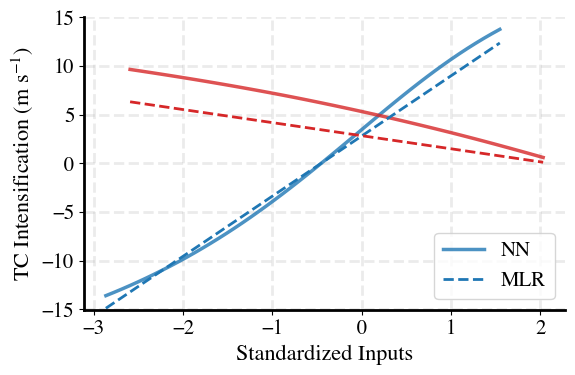

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(PDPs_SHIPSplus_1[0][1],[obj.mean() for obj in PDPs_SHIPSplus_1[0][0]],marker='o',mfc='w',markersize=0,lw=2.5,alpha=0.8,mec='tab:blue',label='NN')
plt.plot(PDPs_SHIPSplus_1[1][1],[obj.mean() for obj in PDPs_SHIPSplus_1[1][0]],marker='o',mfc='w',markersize=0,lw=2.5,alpha=0.8,mec='tab:red',color='tab:red')#,label='T200 NN')
plt.plot(PDPs_SHIPSplus_MLR[0][1],[obj.mean() for obj in PDPs_SHIPSplus_MLR[0][0]], '--', color='tab:blue', alpha=1,lw=2, label='MLR')
plt.plot(PDPs_SHIPSplus_MLR[1][1],[obj.mean() for obj in PDPs_SHIPSplus_MLR[1][0]], '--', color='tab:red', alpha=1,lw=2)#, label='T200 MLR')

plt.grid(alpha=0.25,lw=2,ls='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-15.05,15)
plt.ylabel('TC Intensification (m s$^{-1}$)',fontsize=16)
plt.xlabel('Standardized Inputs',fontsize=16)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('./figures/PDPs_1.png',dpi=600)
plt.show()

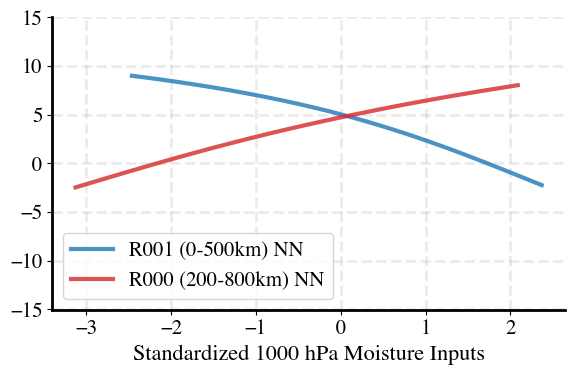

In [15]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(PDPs_SHIPSplus_2[0][1],[obj.mean() for obj in PDPs_SHIPSplus_2[0][0]],marker='o',mfc='w',markersize=0,lw=3,alpha=0.8,mec='tab:blue',label='R001 (0-500km) NN')
plt.plot(PDPs_SHIPSplus_2[1][1],[obj.mean() for obj in PDPs_SHIPSplus_2[1][0]],marker='o',mfc='w',markersize=0,lw=3,alpha=0.8,mec='tab:red',color='tab:red',label='R000 (200-800km) NN')

plt.grid(alpha=0.25,lw=2,ls='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-15.05,15)
#plt.ylabel('TC Intensification (m s$^{-1}$)',fontsize=16)
plt.xlabel('Standardized 1000 hPa Moisture Inputs',fontsize=16)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/PDPs_3.png',dpi=600)
plt.show()

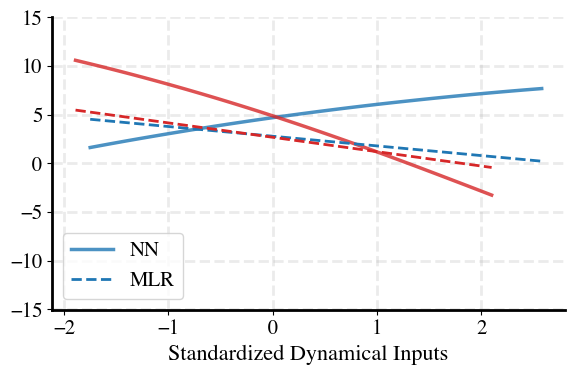

In [16]:
feat_idx_mlr = [var_names_plus_mlr.index('SHL1'),var_names_plus_mlr.index('PVOR')]
PDPs_SHIPSplus_MLR = [get_pdp_mlr(Xtrain=X_mlr,feat_idx=obj,model=mlr_model) for obj in feat_idx_mlr]

fig,ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(PDPs_SHIPSplus_3[0][1],[obj.mean() for obj in PDPs_SHIPSplus_3[0][0]],marker='o',mfc='w',markersize=0,lw=2.5,alpha=0.8,mec='tab:blue',label='NN')
plt.plot(PDPs_SHIPSplus_3[1][1],[obj.mean() for obj in PDPs_SHIPSplus_3[1][0]],marker='o',mfc='w',markersize=0,lw=2.5,alpha=0.8,mec='tab:red',color='tab:red')
plt.plot(PDPs_SHIPSplus_MLR[0][1],[obj.mean() for obj in PDPs_SHIPSplus_MLR[0][0]], '--', color='tab:blue', alpha=1,lw=2, label='MLR')
plt.plot(PDPs_SHIPSplus_MLR[1][1],[obj.mean() for obj in PDPs_SHIPSplus_MLR[1][0]], '--', color='tab:red', alpha=1,lw=2)

plt.grid(alpha=0.25,lw=2,ls='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-15.05,15)
#plt.ylabel('TC Intensification (m s$^{-1}$)',fontsize=16)
plt.xlabel('Standardized Dynamical Inputs',fontsize=16)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/PDPs_2.png',dpi=600)
plt.show()

## Script to produce MLP PDPs

In [ ]:
device='cpu'
# %% Define simple MLP model with 4 hidden layers, ReLU activation in hidden layers, and tanh activation in output layer
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
 
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

def get_pdp(Xtrain=score_nocausal_plus[izlc]['X']['train'],feat_idx=None,model=None):
    xs = Xtrain.copy()[:, feat_idx]
    q = np.quantile(xs, [0.01, 0.99])
    grid = np.linspace(q[0], q[1], 50)
    pd_vals = []
    with torch.no_grad():
        for v in grid:
            Xv = Xtrain.copy()
            Xv[:, feat_idx] = v
            t = torch.FloatTensor(Xv).to(device)
            y = model.eval()(t).squeeze(-1).cpu().numpy()
            pd_vals.append(y)
    return pd_vals,grid
    
# Read the trained SHIPS+ model
shipsplus_mlp = './proc/mlp_models_causal_plus_/mlp_models_causal_plus_4.pkl'
with open(shipsplus_mlp, 'rb') as f:
    plusships_mlp = pickle.load(f, encoding="latin1")

# This paper focus on the results on cross-validation fold 3
izlc = 3

# Initialize a MLP model
model = MLP(27,512,1) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(plusships_mlp[f'results_fold_{izlc}.pkl']['model_state'], strict=False)

feat_idx = [var_names_plus.index('POT'),var_names_plus.index('T200')]
PDPs_SHIPSplus = [get_pdp(feat_idx=obj,model=model) for obj in feat_idx]

feat_idx = [var_names_plus.index('SHL1'),var_names_plus.index('PVOR')]
PDPs_SHIPSplus = [get_pdp(feat_idx=obj,model=model) for obj in feat_idx]